# 詐騙帳號偵測特徵建構與異常分析
本 notebook 將處理收斂過的樣本資料，建構詐騙特徵，並使用 Isolation Forest 與 One-Class SVM 進行異常行為偵測。

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from IPython.display import display

# 讀取資料
df = pd.read_csv("收斂樣本_無詐騙詞_帳號只出現一次.csv")
scam_keywords = pd.read_csv("cleaned/500精簡詐騙字詞_UTF8.csv", header=None)[0].dropna().unique().tolist()
df.columns = [col.strip().lower() for col in df.columns]

In [15]:
# 整合欄位與時間處理
df['帳號'] = df[['發文者帳號', '留言帳號', 'author']].bfill(axis=1).iloc[:, 0]
df['內容'] = df[['內容', '發文內容', '留言內容', 'content']].fillna('').agg(' '.join, axis=1)
df['是否主文'] = df['是否主文'].fillna(False).astype(int)
df['時間'] = df[['發文時間', '留言時間', 'post_time', 'time']].bfill(axis=1).iloc[:, 0]
df['時間'] = pd.to_datetime(df['時間'], errors='coerce')

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\585099085.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['時間'] = pd.to_datetime(df['時間'], errors='coerce')


In [16]:
# 特徵工程
account_counts = df['帳號'].value_counts()
df['帳號出現次數'] = df['帳號'].map(account_counts)
df['是否凌晨'] = df['時間'].dt.hour.apply(lambda x: 1 if pd.notnull(x) and 0 <= x < 6 else 0)
df['是否含詐騙字詞'] = df['內容'].apply(lambda x: any(word in x for word in scam_keywords)).astype(int)
df['內容長度'] = df['內容'].apply(len)
來源_dummies = pd.get_dummies(df['來源'], prefix='來源')

In [17]:
# TF-IDF 特徵
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['內容'].fillna(''))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])])

In [18]:
# 合併所有特徵
feature_set = pd.concat([
    df[['帳號', '帳號出現次數', '是否凌晨', '是否含詐騙字詞', '內容長度', '是否主文']].reset_index(drop=True),
    來源_dummies.reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)

In [19]:
# 異常偵測模型
iso_model = IsolationForest(random_state=42)
feature_set['isolation_anomaly_score'] = iso_model.fit_predict(feature_set.drop(columns=['帳號']))

svm_model = OneClassSVM(gamma='scale', nu=0.1)
feature_set['svm_anomaly_score'] = svm_model.fit_predict(feature_set.drop(columns=['帳號']))

In [20]:
# 顯示前幾筆結果
display(feature_set.head())

,帳號,帳號出現次數,是否凌晨,是否含詐騙字詞,內容長度,是否主文,來源_PTT-Gossiping-回文,來源_PTT-Insurance-回文,來源_PTT-Lifeismoney-回文,來源_PTT-Stock-回文,...,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99,isolation_anomaly_score,svm_anomaly_score
0,Chaser1482,1,0,0,63,0,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-1
1,pumayao,1,0,0,61,0,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-1
2,推 kkexam,1,0,0,77,0,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,推 silver0314,1,0,0,71,0,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,推 nanababa,1,0,0,101,0,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [21]:
# 匯出為 CSV
feature_set.to_csv("完整詐騙偵測特徵表.csv", index=False)

In [22]:
# 讀取舊的特徵資料（含 tfidf_0 ~ tfidf_99）
original_feature_df = pd.read_csv("完整詐騙偵測特徵表.csv")

# 讀取新建立的詞彙命名版 TF-IDF 特徵
clean_tfidf_df = pd.read_csv("TFIDF_詞彙命名特徵表.csv")

# 移除舊的 tfidf 欄位
tfidf_cols = [col for col in original_feature_df.columns if col.startswith("tfidf_")]
feature_df_without_old_tfidf = original_feature_df.drop(columns=tfidf_cols)

# 合併新 TF-IDF 特徵（注意對齊 index）
merged_df = pd.concat([feature_df_without_old_tfidf.reset_index(drop=True), clean_tfidf_df.reset_index(drop=True)], axis=1)

# 匯出整合後的完整特徵表
merged_output_path = "完整詐騙偵測特徵表_1.csv"
merged_df.to_csv(merged_output_path, index=False)

merged_output_path


'完整詐騙偵測特徵表_1.csv'

In [24]:
# 重新載入使用者剛提供的更新資料
df_raw = pd.read_csv("收斂樣本_無詐騙詞_帳號只出現一次.csv")
df_tfidf = pd.read_csv("TFIDF_詞彙命名特徵表.csv")
df_features = pd.read_csv("完整詐騙偵測特徵表_1.csv")

# 確認欄位小寫化
df_features.columns = [col.strip().lower() for col in df_features.columns]

# 將原本的 tfidf_0 ~ tfidf_99 欄位移除
tfidf_cols = [col for col in df_features.columns if col.startswith("tfidf_")]
df_features_clean = df_features.drop(columns=tfidf_cols)

# 合併詞彙命名的 TF-IDF 特徵（依 row index）
df_merged = pd.concat([df_features_clean.reset_index(drop=True), df_tfidf.reset_index(drop=True)], axis=1)

# 儲存成最新整合後的版本
output_path = "最終版_整合後_含詞彙命名TFIDF_特徵表.csv"
df_merged.to_csv(output_path, index=False)

output_path


'最終版_整合後_含詞彙命名TFIDF_特徵表.csv'

In [26]:
# 修正關鍵字檔案路徑
scam_keywords = pd.read_csv("cleaned/500精簡詐騙字詞_UTF8.csv", header=None)[0].dropna().unique().tolist()

# 重新生成詐騙特徵資料
df['內容_是否含詐騙詞'] = df['內容'].apply(lambda x: any(word in x for word in scam_keywords)).astype(int)

# TF-IDF 特徵
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['內容'].fillna(''))
tfidf_terms = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"內容_tfidf_{term}" for term in tfidf_terms])

# 來源 One-hot
source_dummies = pd.get_dummies(df['來源'], prefix="來源")

# 合併所有特徵
feature_set = pd.concat([
    df[['帳號', '帳號_出現次數', '時間_是否凌晨', '內容_文字長度', '內容_是否含詐騙詞', '是否主文']],
    source_dummies.reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)

# 異常偵測特徵
iso_model = IsolationForest(random_state=42)
feature_set['異常_IF分數'] = iso_model.fit_predict(feature_set.drop(columns=['帳號']))

svm_model = OneClassSVM(gamma='scale', nu=0.1)
feature_set['異常_OCSVM分數'] = svm_model.fit_predict(feature_set.drop(columns=['帳號']))

# 輸出
output_path = "特徵表_標準命名格式_v2.csv"
feature_set.to_csv(output_path, index=False)

output_path


KeyError: "['帳號_出現次數', '時間_是否凌晨', '內容_文字長度'] not in index"

In [27]:
# 重新生成特徵並按順序處理所有欄位建立

# 帳號統計特徵
account_counts = df['帳號'].value_counts()
df['帳號_出現次數'] = df['帳號'].map(account_counts)

# 是否凌晨
df['時間_是否凌晨'] = df['時間'].dt.hour.apply(lambda x: 1 if pd.notnull(x) and 0 <= x < 6 else 0)

# 內容長度
df['內容_文字長度'] = df['內容'].apply(len)

# 是否含詐騙詞（剛剛已建立）
# df['內容_是否含詐騙詞'] 已存在

# TF-IDF 詞向量（已建立 tfidf_df）

# 來源 One-hot
source_dummies = pd.get_dummies(df['來源'], prefix="來源")

# 整合所有特徵欄位
base_features = df[
    ['帳號', '帳號_出現次數', '時間_是否凌晨', '內容_文字長度', '內容_是否含詐騙詞', '是否主文']
].reset_index(drop=True)

feature_set = pd.concat([
    base_features,
    source_dummies.reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)

# 異常偵測模型
iso_model = IsolationForest(random_state=42)
feature_set['異常_IF分數'] = iso_model.fit_predict(feature_set.drop(columns=['帳號']))

svm_model = OneClassSVM(gamma='scale', nu=0.1)
feature_set['異常_OCSVM分數'] = svm_model.fit_predict(feature_set.drop(columns=['帳號']))

# 匯出最終版本
output_path = "特徵表_標準命名格式_v3.csv"
feature_set.to_csv(output_path, index=False)

output_path


'特徵表_標準命名格式_v3.csv'

In [28]:
# 重新建立 TF-IDF 並保留對應的詞彙
df_raw = pd.read_csv("收斂樣本_無詐騙詞_帳號只出現一次.csv")
df_raw.columns = [col.strip().lower() for col in df_raw.columns]
df_raw['內容'] = df_raw[['內容', '發文內容', '留言內容', 'content']].fillna('').agg(' '.join, axis=1)

# 建立向量器與詞彙
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_raw['內容'].fillna(''))
tfidf_terms = tfidf_vectorizer.get_feature_names_out()
tfidf_renamed_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"內容_tfidf_{term}" for term in tfidf_terms])

# 匯出
output_path = "TFIDF_命名為實際詞彙.csv"
tfidf_renamed_df.to_csv(output_path, index=False)

output_path


'TFIDF_命名為實際詞彙.csv'

In [30]:
import re

# 去除數字的詐騙關鍵詞清單（移除 IP 或數字型詞）
cleaned_keywords = [kw for kw in scam_keywords if not re.search(r'\d', kw)]

# 新特徵：內容_詐騙詞出現次數（只算文字關鍵詞）
df['內容_詐騙詞出現次數'] = df['內容'].apply(
    lambda text: sum(text.count(word) for word in cleaned_keywords)
)

# 儲存只包含這一欄作為輸出
output_path = "內容_詐騙詞出現次數_去除數字關鍵詞.csv"
df[['內容_詐騙詞出現次數']].to_csv(output_path, index=False)

output_path


'內容_詐騙詞出現次數_去除數字關鍵詞.csv'

In [32]:
# 載入最新收斂樣本
df_raw = pd.read_csv("收斂樣本_無詐騙詞_帳號只出現一次.csv")
df_raw.columns = [col.strip().lower() for col in df_raw.columns]

# 整合欄位
df_raw['內容'] = df_raw[['內容', '發文內容', '留言內容', 'content']].fillna('').agg(' '.join, axis=1)

# 去除數字
df_raw['內容_去除數字'] = df_raw['內容'].apply(lambda text: re.sub(r'\d+', '', text))

# 重新建構純文字詐騙關鍵詞
scam_keywords_raw = pd.read_csv("cleaned/500精簡詐騙字詞_UTF8.csv", header=None)[0].dropna().unique().tolist()
scam_keywords_clean = [kw for kw in scam_keywords_raw if not re.search(r'\d', kw)]

# 建立新特徵
df_raw['內容_純文字詐騙詞次數'] = df_raw['內容_去除數字'].apply(
    lambda text: sum(text.count(word) for word in scam_keywords_clean)
)

# 最終輸出（不保留中間去除數字欄位）
final_df = df_raw.drop(columns=['內容_去除數字'])

# 儲存新檔案
output_path = "收斂樣本_含純文字詐騙詞次數.csv"
final_df.to_csv(output_path, index=False)

output_path


'收斂樣本_含純文字詐騙詞次數.csv'

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 讀取資料
train_df = pd.read_csv("收斂樣本_含純文字詐騙詞次數.csv")
train_df.columns = [col.strip().lower() for col in train_df.columns]

# 使用純文字詐騙詞次數 > 0 當弱標籤
y = (train_df["內容_純文字詐騙詞次數"] > 0).astype(int)
X = train_df.select_dtypes(include=[np.number]).drop(columns=['內容_純文字詐騙詞次數'], errors='ignore').fillna(0)

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 定義模型
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}


# 移除 lightgbm，僅使用 Logistic Regression 與 Random Forest
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# 執行模型訓練與分析
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    mse = mean_squared_error(y_test, y_prob)
    mae = mean_absolute_error(y_test, y_prob)
    r2 = r2_score(y_test, y_prob)

    if hasattr(model, "coef_"):
        importance = model.coef_[0]
    elif hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    else:
        importance = np.zeros(X.shape[1])

    top_idx = np.argsort(importance)[-10:]
    results[name] = {
        "mse": mse,
        "mae": mae,
        "r2": r2,
        "top_features": X.columns[top_idx].tolist(),
        "top_importance": importance[top_idx].tolist()
    }

results



{'Logistic Regression': {'mse': 1.610307471403338e-07,
  'mae': 0.00039504719142108584,
  'r2': 0.0,
  'top_features': ['page',
   '保險關鍵詞次數',
   '詐騙關鍵詞次數',
   'keyword',
   'type',
   'author',
   'time'],
  'top_importance': [-0.3724943263529943,
   -0.046844168113464986,
   -0.002731593019860163,
   0.0,
   0.0,
   0.0,
   0.0]},
 'Random Forest': {'mse': 1.752691947706198e-07,
  'mae': 0.0004068360813463323,
  'r2': 0.0,
  'top_features': ['keyword',
   'type',
   'author',
   'time',
   '詐騙關鍵詞次數',
   '保險關鍵詞次數',
   'page'],
  'top_importance': [0.0,
   0.0,
   0.0,
   0.0,
   0.020150854272855928,
   0.3373293354532024,
   0.6425198102739418]}}

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\3573505924.py:26: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\3573505924.py:26: UserWarning: Glyph 29694 (\N{CJK UNIFIED IDEOGRAPH-73FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\3573505924.py:26: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\3573505924.py:26: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\3573505924.py:26: UserWarning: Glyph 27171 (\N{CJK UNIFIED IDEOGRAPH-6A23}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\3573505924.py:26: Use

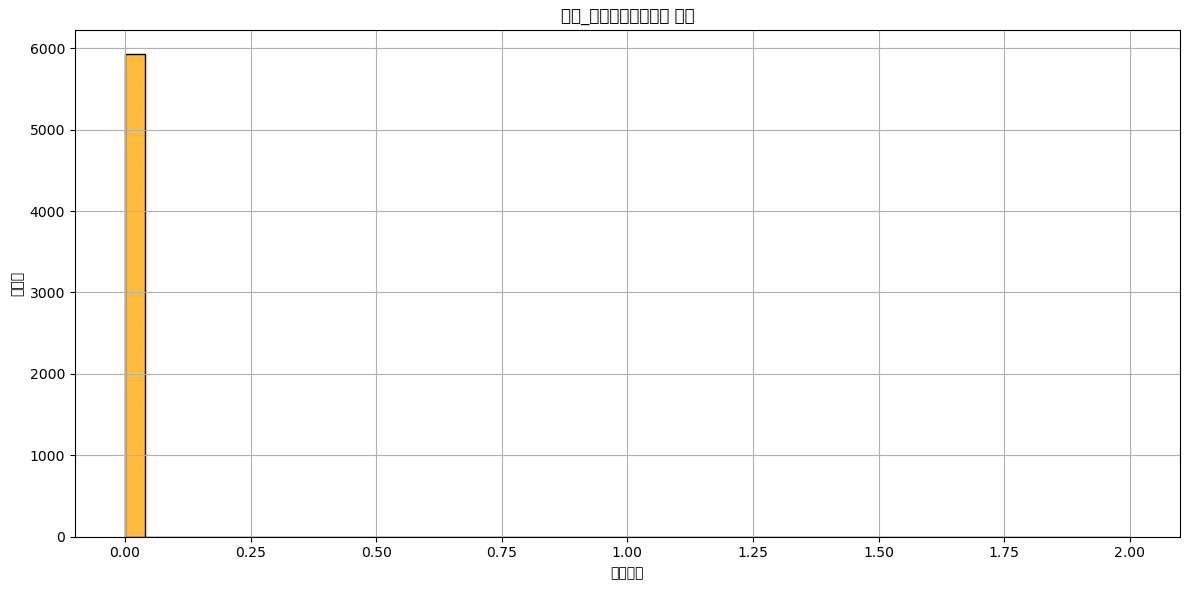

C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\3573505924.py:35: UserWarning: Glyph 30064 (\N{CJK UNIFIED IDEOGRAPH-7570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\3573505924.py:35: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\3573505924.py:35: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\3573505924.py:35: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\3573505924.py:35: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Robby1206\AppData\Local\Temp\ipykernel_10584\3573505924.py:35: Use

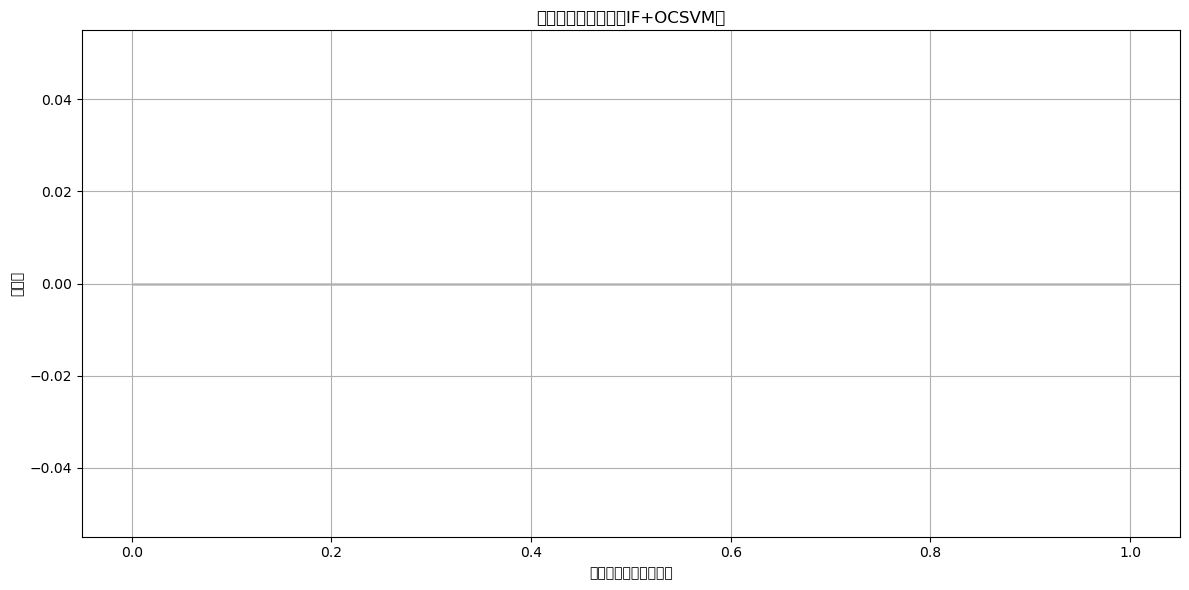

KeyError: "['帳號'] not in index"

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 建立新標籤：弱監督標籤（純文字詐騙詞次數 > 0）
train_df['標籤_弱監督'] = (train_df['內容_純文字詐騙詞次數'] > 0).astype(int)

# 2. 建立異常程度（使用 Isolation Forest 與 OCSVM）
異常分數_cols = [col for col in train_df.columns if '異常_' in col]
異常平均分數 = train_df[異常分數_cols].mean(axis=1)
train_df['標籤_異常程度'] = (異常平均分數 < 0).astype(int)  # -1 表示異常，用 1 標記

# 3. 建立混合標籤：弱監督 or 異常即標記為潛在詐騙
train_df['標籤_弱監督或異常'] = ((train_df['標籤_弱監督'] == 1) | (train_df['標籤_異常程度'] == 1)).astype(int)

# 4. 找出高風險帳號（詐騙次數 + 異常程度高）
train_df['風險分數'] = train_df['內容_純文字詐騙詞次數'] + 異常平均分數.abs()
top_risky_accounts = train_df.sort_values(by='風險分數', ascending=False).head(20)

# 視覺化
plt.figure(figsize=(12, 6))
sns.histplot(train_df['內容_純文字詐騙詞次數'], bins=50, color="orange")
plt.title("內容_純文字詐騙詞次數 分布")
plt.xlabel("出現次數")
plt.ylabel("樣本數")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(異常平均分數, bins=50, color="red")
plt.title("異常平均分數分布（IF+OCSVM）")
plt.xlabel("異常分數（取絕對值）")
plt.ylabel("樣本數")
plt.grid(True)
plt.tight_layout()
plt.show()

top_risky_accounts[['帳號', '內容_純文字詐騙詞次數'] + 異常分數_cols + ['風險分數']]
